<a href="https://colab.research.google.com/github/mlubega/cv/blob/master/TrainFacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Enable CUDA GPU
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
# Only need to do once
#%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/
#!ls -l
#!tar -xzvf crops.tar.gz

In [0]:
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/crops/
!ls -l

/content/drive/My Drive/City Msc Data Science/ComputerVision/crops
total 19
-rw------- 1 root root 6477 Apr 18 17:23  juan.jpg
drwx------ 2 root root 4096 Apr 22 16:35 'model(?)'
drwx------ 2 root root 4096 Apr 16 18:53  test
drwx------ 2 root root 4096 Apr 16 18:53  train


Downgrade OPENCV version to access SIFT/SURF

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 4.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


# SVM/MLP Training


In [0]:
import cv2
import numpy as np
import os
from functools import reduce
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import time

In [0]:
cv2.__version__

'3.4.2'

In [0]:
import timeit
import time

class Timer(object):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()
        return self

    def __exit__(self, *args):
        self.end = timeit.default_timer()
        self.secs = self.end - self.start
        self.msecs = self.secs * 1000  # millisecs
        if self.verbose:
            print("elapsed time:", self.msecs)

In [0]:
TRAIN_DATA = 'train/'
TEST_DATA  = 'test/'

NUM_CLASSES = len(os.listdir(TRAIN_DATA))
K = NUM_CLASSES * 5  # KMeans Classes

sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create()

def getSIFTfeatures(gray_img):
    #sift = cv2.xfeatures2d.SIFT_create() #What threshold?
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def getSURFfeatures(gray_img):  
    #surf = cv2.xfeatures2d.SURF_create() #what threshold?
    surf.setExtended(True) # --> to expand to 128 dim.
    kp, desc = surf.detectAndCompute(gray_img, None)
    return kp, desc

def getORBfeatures(gray_img):
    # Initiate ORB detector
    #orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(gray_img,None)
    # compute the descriptors with ORB
    kp, desc = orb.compute(gray_img, kp)
    return kp, desc

def extractFeatures(crop_list, featureFunc):
    descriptors = {}
    
    for i in range(0, len(crop_list)):
       # gray = cv2.cvtColor(crop_list[i], cv2.COLOR_BGR2GRAY)
        kp, desc = featureFunc(crop_list[i])
        if type(desc) == type(None):
          print('No Features Extracted')
          continue
          
        descriptors[i] = desc
        
    return descriptors
  
def groupAllFeatures(desc_hash):
    all_desc = []
    for person, crops in desc_hash.items():
        for idx, descs in crops.items():
            all_desc.extend(descs)
            
    return all_desc
        

def trainKMeans(descriptors):
     
    # Train KMeans
    initial_size = 3 * K
    batch_size = int(len(descriptors) / 3)  # What's a good metric to determine this number? 
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=batch_size, init_size=initial_size, verbose=0).fit(descriptors)
    
    return kmeans
    
def generateHistograms(descriptors, kmeans_centers):
    
    ## Generate Histogram 
    histograms = []
    for i, desc in descriptors.items(): 
        preds = kmeans_centers.predict(desc)
        hist, bin_edges=np.histogram(preds, bins=range(0, K)) # Normalize by number of keypoints?? 
        histograms.append(hist)
    
    return histograms


#### Extract features separately  in order to time

In [0]:
allSIFT = {}

people = os.listdir(TRAIN_DATA)    

wall_start, cpu_start = time.time(), time.clock()
i, total = 0,len(people)

with Timer() as t:
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )

      #read in cropped data
      crop_names = os.listdir(os.path.join(TRAIN_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TRAIN_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]

      # get SIFT Features
      sift_desc = extractFeatures(crops, getSIFTfeatures)
      allSIFT[person] = sift_desc
      print("Extracted SIFT")

print("\n","Time", t.secs)


Processing Sub Dir 43 [ 1 / 69 ]
Extracted SIFT
Processing Sub Dir 66 [ 2 / 69 ]
Extracted SIFT
Processing Sub Dir 24 [ 3 / 69 ]
Extracted SIFT
Processing Sub Dir 8 [ 4 / 69 ]
Extracted SIFT
Processing Sub Dir 54 [ 5 / 69 ]
Extracted SIFT
Processing Sub Dir 22 [ 6 / 69 ]
Extracted SIFT
Processing Sub Dir 11 [ 7 / 69 ]
Extracted SIFT
Processing Sub Dir 76 [ 8 / 69 ]
Extracted SIFT
Processing Sub Dir 69 [ 9 / 69 ]
Extracted SIFT
Processing Sub Dir 74 [ 10 / 69 ]
Extracted SIFT
Processing Sub Dir 9 [ 11 / 69 ]
Extracted SIFT
Processing Sub Dir 13 [ 12 / 69 ]
Extracted SIFT
Processing Sub Dir 38 [ 13 / 69 ]
Extracted SIFT
Processing Sub Dir 81 [ 14 / 69 ]
Extracted SIFT
Processing Sub Dir 67 [ 15 / 69 ]
Extracted SIFT
Processing Sub Dir 55 [ 16 / 69 ]
Extracted SIFT
Processing Sub Dir 65 [ 17 / 69 ]
Extracted SIFT
Processing Sub Dir 41 [ 18 / 69 ]
Extracted SIFT
Processing Sub Dir 7 [ 19 / 69 ]
Extracted SIFT
Processing Sub Dir 45 [ 20 / 69 ]
Extracted SIFT
Processing Sub Dir 78 [ 21 / 69 

In [0]:
allSURF = {}
people = os.listdir(TRAIN_DATA)    

i, total = 0,len(people)

with Timer() as t:
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )


      #read in cropped data
      crop_names = os.listdir(os.path.join(TRAIN_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TRAIN_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]

      # get SURF Features
      surf_desc = extractFeatures(crops, getSURFfeatures)
      allSURF[person] = surf_desc
      print("Extracted SURF")

                 
print("\n","Time", t.secs)                 



Processing Sub Dir 43 [ 1 / 69 ]
Extracted SURF
Processing Sub Dir 66 [ 2 / 69 ]
Extracted SURF
Processing Sub Dir 24 [ 3 / 69 ]
Extracted SURF
Processing Sub Dir 8 [ 4 / 69 ]
Extracted SURF
Processing Sub Dir 54 [ 5 / 69 ]
Extracted SURF
Processing Sub Dir 22 [ 6 / 69 ]
Extracted SURF
Processing Sub Dir 11 [ 7 / 69 ]
Extracted SURF
Processing Sub Dir 76 [ 8 / 69 ]
Extracted SURF
Processing Sub Dir 69 [ 9 / 69 ]
Extracted SURF
Processing Sub Dir 74 [ 10 / 69 ]
Extracted SURF
Processing Sub Dir 9 [ 11 / 69 ]
Extracted SURF
Processing Sub Dir 13 [ 12 / 69 ]
Extracted SURF
Processing Sub Dir 38 [ 13 / 69 ]
Extracted SURF
Processing Sub Dir 81 [ 14 / 69 ]
Extracted SURF
Processing Sub Dir 67 [ 15 / 69 ]
Extracted SURF
Processing Sub Dir 55 [ 16 / 69 ]
Extracted SURF
Processing Sub Dir 65 [ 17 / 69 ]
Extracted SURF
Processing Sub Dir 41 [ 18 / 69 ]
Extracted SURF
Processing Sub Dir 7 [ 19 / 69 ]
Extracted SURF
Processing Sub Dir 45 [ 20 / 69 ]
Extracted SURF
Processing Sub Dir 78 [ 21 / 69 

In [0]:
allORB = {}

people = os.listdir(TRAIN_DATA)    


i, total = 0,len(people)
with Timer() as t:
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )


      #read in cropped data
      crop_names = os.listdir(os.path.join(TRAIN_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TRAIN_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]

      # get ORB Features
      orb_desc = extractFeatures(crops, getORBfeatures)
      allORB[person] = orb_desc
      print("Extracted ORB")
                 
print("\n", "Time", t.secs)                  

Processing Sub Dir 43 [ 1 / 69 ]
Extracted ORB
Processing Sub Dir 66 [ 2 / 69 ]
Extracted ORB
Processing Sub Dir 24 [ 3 / 69 ]
Extracted ORB
Processing Sub Dir 8 [ 4 / 69 ]
Extracted ORB
Processing Sub Dir 54 [ 5 / 69 ]
Extracted ORB
Processing Sub Dir 22 [ 6 / 69 ]
Extracted ORB
Processing Sub Dir 11 [ 7 / 69 ]
Extracted ORB
Processing Sub Dir 76 [ 8 / 69 ]
Extracted ORB
Processing Sub Dir 69 [ 9 / 69 ]
Extracted ORB
Processing Sub Dir 74 [ 10 / 69 ]
Extracted ORB
Processing Sub Dir 9 [ 11 / 69 ]
Extracted ORB
Processing Sub Dir 13 [ 12 / 69 ]
Extracted ORB
Processing Sub Dir 38 [ 13 / 69 ]
Extracted ORB
Processing Sub Dir 81 [ 14 / 69 ]
Extracted ORB
Processing Sub Dir 67 [ 15 / 69 ]
Extracted ORB
Processing Sub Dir 55 [ 16 / 69 ]
Extracted ORB
Processing Sub Dir 65 [ 17 / 69 ]
Extracted ORB
Processing Sub Dir 41 [ 18 / 69 ]
Extracted ORB
Processing Sub Dir 7 [ 19 / 69 ]
Extracted ORB
Processing Sub Dir 45 [ 20 / 69 ]
Extracted ORB
Processing Sub Dir 78 [ 21 / 69 ]
Extracted ORB
Proc

#### Create Bag of Visual Words

In [0]:
### Group Features

sift_matrix = groupAllFeatures(allSIFT)
surf_matrix = groupAllFeatures(allSURF)
orb_matrix = groupAllFeatures(allORB)

### Train KMeans
sift_kmeans = None
surf_kmeans = None
orb_kmeans = None

print("Training SIFT KMeans")
sift_kmeans = trainKMeans(sift_matrix)

print("Training SURF KMeans")
surf_kmeans = trainKMeans(surf_matrix)

print("Training ORB KMeans")
orb_kmeans = trainKMeans(orb_matrix)

Training SIFT KMeans
Training SURF KMeans
Training ORB KMeans


#### Prepare Training Data

In [0]:
sift_train_feature_vec = [[], []]   
   

print("SURF Training Data")
people = os.listdir(TRAIN_DATA)    

i, total = 0,len(people)
with Timer() as t: 
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )


      sift_histograms = generateHistograms(allSIFT[person], sift_kmeans)
      sift_train_feature_vec[0].extend(sift_histograms)
      sift_train_feature_vec[1].extend([person] * len(sift_histograms))

    
    

print("\n", "Time", t.secs)

SURF Training Data
Processing Sub Dir 43 [ 1 / 69 ]
Processing Sub Dir 66 [ 2 / 69 ]
Processing Sub Dir 24 [ 3 / 69 ]
Processing Sub Dir 8 [ 4 / 69 ]
Processing Sub Dir 54 [ 5 / 69 ]
Processing Sub Dir 22 [ 6 / 69 ]
Processing Sub Dir 11 [ 7 / 69 ]
Processing Sub Dir 76 [ 8 / 69 ]
Processing Sub Dir 69 [ 9 / 69 ]
Processing Sub Dir 74 [ 10 / 69 ]
Processing Sub Dir 9 [ 11 / 69 ]
Processing Sub Dir 13 [ 12 / 69 ]
Processing Sub Dir 38 [ 13 / 69 ]
Processing Sub Dir 81 [ 14 / 69 ]
Processing Sub Dir 67 [ 15 / 69 ]
Processing Sub Dir 55 [ 16 / 69 ]
Processing Sub Dir 65 [ 17 / 69 ]
Processing Sub Dir 41 [ 18 / 69 ]
Processing Sub Dir 7 [ 19 / 69 ]
Processing Sub Dir 45 [ 20 / 69 ]
Processing Sub Dir 78 [ 21 / 69 ]
Processing Sub Dir 50 [ 22 / 69 ]
Processing Sub Dir 62 [ 23 / 69 ]
Processing Sub Dir 44 [ 24 / 69 ]
Processing Sub Dir 75 [ 25 / 69 ]
Processing Sub Dir 60 [ 26 / 69 ]
Processing Sub Dir 57 [ 27 / 69 ]
Processing Sub Dir 40 [ 28 / 69 ]
Processing Sub Dir 21 [ 29 / 69 ]
Process

In [0]:
surf_train_feature_vec = [[], []]   
 
print("SURF Training Data")
people = os.listdir(TRAIN_DATA)    


i, total = 0,len(people)
with Timer() as t:
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )

      # get SURF Features
      surf_histograms = generateHistograms(allSURF[person], surf_kmeans)
      surf_train_feature_vec[0].extend(surf_histograms)
      surf_train_feature_vec[1].extend([person] * len(surf_histograms))
    
print("\n", "Time", t.secs)

SURF Training Data
Processing Sub Dir 43 [ 1 / 69 ]
Processing Sub Dir 66 [ 2 / 69 ]
Processing Sub Dir 24 [ 3 / 69 ]
Processing Sub Dir 8 [ 4 / 69 ]
Processing Sub Dir 54 [ 5 / 69 ]
Processing Sub Dir 22 [ 6 / 69 ]
Processing Sub Dir 11 [ 7 / 69 ]
Processing Sub Dir 76 [ 8 / 69 ]
Processing Sub Dir 69 [ 9 / 69 ]
Processing Sub Dir 74 [ 10 / 69 ]
Processing Sub Dir 9 [ 11 / 69 ]
Processing Sub Dir 13 [ 12 / 69 ]
Processing Sub Dir 38 [ 13 / 69 ]
Processing Sub Dir 81 [ 14 / 69 ]
Processing Sub Dir 67 [ 15 / 69 ]
Processing Sub Dir 55 [ 16 / 69 ]
Processing Sub Dir 65 [ 17 / 69 ]
Processing Sub Dir 41 [ 18 / 69 ]
Processing Sub Dir 7 [ 19 / 69 ]
Processing Sub Dir 45 [ 20 / 69 ]
Processing Sub Dir 78 [ 21 / 69 ]
Processing Sub Dir 50 [ 22 / 69 ]
Processing Sub Dir 62 [ 23 / 69 ]
Processing Sub Dir 44 [ 24 / 69 ]
Processing Sub Dir 75 [ 25 / 69 ]
Processing Sub Dir 60 [ 26 / 69 ]
Processing Sub Dir 57 [ 27 / 69 ]
Processing Sub Dir 40 [ 28 / 69 ]
Processing Sub Dir 21 [ 29 / 69 ]
Process

In [0]:
 orb_train_feature_vec = [[], []]   

print("ORB Training Data")
people = os.listdir(TRAIN_DATA)    

i, total = 0,len(people)
with Timer() as t:
  for person in people:
      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )

      # get ORB Features
      orb_histograms = generateHistograms(allORB[person], orb_kmeans)
      orb_train_feature_vec[0].extend(orb_histograms)
      orb_train_feature_vec[1].extend([person] * len(orb_histograms))
    

    
print("\n", "Time", t.secs)

ORB Training Data
Processing Sub Dir 43 [ 1 / 69 ]
Processing Sub Dir 66 [ 2 / 69 ]
Processing Sub Dir 24 [ 3 / 69 ]
Processing Sub Dir 8 [ 4 / 69 ]
Processing Sub Dir 54 [ 5 / 69 ]
Processing Sub Dir 22 [ 6 / 69 ]
Processing Sub Dir 11 [ 7 / 69 ]
Processing Sub Dir 76 [ 8 / 69 ]
Processing Sub Dir 69 [ 9 / 69 ]
Processing Sub Dir 74 [ 10 / 69 ]
Processing Sub Dir 9 [ 11 / 69 ]
Processing Sub Dir 13 [ 12 / 69 ]
Processing Sub Dir 38 [ 13 / 69 ]
Processing Sub Dir 81 [ 14 / 69 ]
Processing Sub Dir 67 [ 15 / 69 ]
Processing Sub Dir 55 [ 16 / 69 ]
Processing Sub Dir 65 [ 17 / 69 ]
Processing Sub Dir 41 [ 18 / 69 ]
Processing Sub Dir 7 [ 19 / 69 ]
Processing Sub Dir 45 [ 20 / 69 ]
Processing Sub Dir 78 [ 21 / 69 ]
Processing Sub Dir 50 [ 22 / 69 ]
Processing Sub Dir 62 [ 23 / 69 ]
Processing Sub Dir 44 [ 24 / 69 ]
Processing Sub Dir 75 [ 25 / 69 ]
Processing Sub Dir 60 [ 26 / 69 ]
Processing Sub Dir 57 [ 27 / 69 ]
Processing Sub Dir 40 [ 28 / 69 ]
Processing Sub Dir 21 [ 29 / 69 ]
Processi

#### Prepare Test Data

In [0]:
sift_test_feature_vec = [[], []] 


print("SIFT Test Data")
people = os.listdir(TEST_DATA) 


i, total = 0,len(people)
with Timer() as t:
  for person in people:

      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )
      
      
      crop_names = os.listdir(os.path.join(TEST_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TEST_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]
      
      # get SIFT Features
      sift_desc = extractFeatures(crops, getSIFTfeatures)
      
      # get histograms
      sift_histograms = generateHistograms(sift_desc, sift_kmeans)
      sift_test_feature_vec[0].extend(sift_histograms)
      sift_test_feature_vec[1].extend([person] * len(sift_histograms))
    
print("\n", "Time", t.secs)

SIFT Test Data
Processing Sub Dir 43 [ 1 / 69 ]
Processing Sub Dir 22 [ 2 / 69 ]
Processing Sub Dir 74 [ 3 / 69 ]
Processing Sub Dir 11 [ 4 / 69 ]
Processing Sub Dir 9 [ 5 / 69 ]
Processing Sub Dir 8 [ 6 / 69 ]
Processing Sub Dir 76 [ 7 / 69 ]
Processing Sub Dir 69 [ 8 / 69 ]
Processing Sub Dir 54 [ 9 / 69 ]
Processing Sub Dir 24 [ 10 / 69 ]
Processing Sub Dir 78 [ 11 / 69 ]
Processing Sub Dir 65 [ 12 / 69 ]
Processing Sub Dir 67 [ 13 / 69 ]
Processing Sub Dir 55 [ 14 / 69 ]
Processing Sub Dir 81 [ 15 / 69 ]
Processing Sub Dir 13 [ 16 / 69 ]
Processing Sub Dir 66 [ 17 / 69 ]
Processing Sub Dir 7 [ 18 / 69 ]
Processing Sub Dir 38 [ 19 / 69 ]
Processing Sub Dir 41 [ 20 / 69 ]
Processing Sub Dir 40 [ 21 / 69 ]
Processing Sub Dir 45 [ 22 / 69 ]
Processing Sub Dir 15 [ 23 / 69 ]
Processing Sub Dir 12 [ 24 / 69 ]
Processing Sub Dir 75 [ 25 / 69 ]
Processing Sub Dir 60 [ 26 / 69 ]
Processing Sub Dir 50 [ 27 / 69 ]
Processing Sub Dir 21 [ 28 / 69 ]
Processing Sub Dir 57 [ 29 / 69 ]
Processing 

In [0]:
surf_test_feature_vec = [[], []] 


print("SURF Test Data")
people = os.listdir(TEST_DATA) 

i, total = 0,len(people)
with Timer() as t:
  for person in people:

      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]")
       
      crop_names = os.listdir(os.path.join(TEST_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TEST_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]
            
      # get SURFT Features
      surf_desc = extractFeatures(crops, getSURFfeatures)

      # get SURF Features
      surf_histograms = generateHistograms(surf_desc, surf_kmeans)
      surf_test_feature_vec[0].extend(surf_histograms)
      surf_test_feature_vec[1].extend([person] * len(surf_histograms))
      print("Extracted SURF")
    
        
print("\n", "Time", t.secs)

SURF Test Data
Processing Sub Dir 43 [ 1 / 69 ]
Extracted SURF
Processing Sub Dir 22 [ 2 / 69 ]
Extracted SURF
Processing Sub Dir 74 [ 3 / 69 ]
Extracted SURF
Processing Sub Dir 11 [ 4 / 69 ]
Extracted SURF
Processing Sub Dir 9 [ 5 / 69 ]
Extracted SURF
Processing Sub Dir 8 [ 6 / 69 ]
Extracted SURF
Processing Sub Dir 76 [ 7 / 69 ]
Extracted SURF
Processing Sub Dir 69 [ 8 / 69 ]
Extracted SURF
Processing Sub Dir 54 [ 9 / 69 ]
Extracted SURF
Processing Sub Dir 24 [ 10 / 69 ]
Extracted SURF
Processing Sub Dir 78 [ 11 / 69 ]
Extracted SURF
Processing Sub Dir 65 [ 12 / 69 ]
Extracted SURF
Processing Sub Dir 67 [ 13 / 69 ]
Extracted SURF
Processing Sub Dir 55 [ 14 / 69 ]
Extracted SURF
Processing Sub Dir 81 [ 15 / 69 ]
Extracted SURF
Processing Sub Dir 13 [ 16 / 69 ]
Extracted SURF
Processing Sub Dir 66 [ 17 / 69 ]
Extracted SURF
Processing Sub Dir 7 [ 18 / 69 ]
Extracted SURF
Processing Sub Dir 38 [ 19 / 69 ]
Extracted SURF
Processing Sub Dir 41 [ 20 / 69 ]
Extracted SURF
Processing Sub Di

In [0]:
orb_test_feature_vec = [[], []]  


print("ORB Test Data")
people = os.listdir(TEST_DATA) 

i, total = 0,len(people)
with Timer() as t:
  for person in people:

      i += 1
      print("Processing Sub Dir", person, "[", i , "/", total, "]" )

      crop_names = os.listdir(os.path.join(TEST_DATA, person))
      crop_names = list(map(lambda x: os.path.join(TEST_DATA, person, x), crop_names)) 
      crops = [cv2.imread(x , cv2.IMREAD_GRAYSCALE) for x in crop_names ]
      
      # get ORB Features
      orb_desc = extractFeatures(crops, getORBfeatures)
            
      # get ORB Features
      orb_histograms = generateHistograms(orb_desc, orb_kmeans)
      orb_test_feature_vec[0].extend(orb_histograms)
      orb_test_feature_vec[1].extend([person] * len(orb_histograms))

    
    
print("\n", "Time", t.secs)

ORB Test Data
Processing Sub Dir 43 [ 1 / 69 ]
Processing Sub Dir 22 [ 2 / 69 ]
Processing Sub Dir 74 [ 3 / 69 ]
Processing Sub Dir 11 [ 4 / 69 ]
Processing Sub Dir 9 [ 5 / 69 ]
Processing Sub Dir 8 [ 6 / 69 ]
Processing Sub Dir 76 [ 7 / 69 ]
Processing Sub Dir 69 [ 8 / 69 ]
Processing Sub Dir 54 [ 9 / 69 ]
Processing Sub Dir 24 [ 10 / 69 ]
Processing Sub Dir 78 [ 11 / 69 ]
Processing Sub Dir 65 [ 12 / 69 ]
Processing Sub Dir 67 [ 13 / 69 ]
Processing Sub Dir 55 [ 14 / 69 ]
Processing Sub Dir 81 [ 15 / 69 ]
Processing Sub Dir 13 [ 16 / 69 ]
Processing Sub Dir 66 [ 17 / 69 ]
Processing Sub Dir 7 [ 18 / 69 ]
No Features Extracted
Processing Sub Dir 38 [ 19 / 69 ]
Processing Sub Dir 41 [ 20 / 69 ]
Processing Sub Dir 40 [ 21 / 69 ]
Processing Sub Dir 45 [ 22 / 69 ]
Processing Sub Dir 15 [ 23 / 69 ]
Processing Sub Dir 12 [ 24 / 69 ]
Processing Sub Dir 75 [ 25 / 69 ]
Processing Sub Dir 60 [ 26 / 69 ]
Processing Sub Dir 50 [ 27 / 69 ]
Processing Sub Dir 21 [ 28 / 69 ]
Processing Sub Dir 57 [ 

#### Train SVM Models

In [0]:
print("Training SIFT SVM")
svmSIFT = svm.SVC(gamma = 'auto')
svmSIFT.fit(sift_train_feature_vec[0], sift_train_feature_vec[1])

Training SIFT SVM


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
print("Training SURF SVM")
svmSURF = svm.SVC(gamma = 'auto')
svmSURF.fit(surf_train_feature_vec[0], surf_train_feature_vec[1])

Training SURF SVM


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
print("Training  ORB SVM")
svmORB = svm.SVC(gamma = 'auto')
svmORB.fit(orb_train_feature_vec[0], orb_train_feature_vec[1])

Training  ORB SVM


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Train MLP Models

In [0]:
print("Training SIFT MLP")
mlpSIFT = MLPClassifier(verbose=True, early_stopping=True, alpha=0.05, max_iter=600)
mlpSIFT.fit(sift_train_feature_vec[0], sift_train_feature_vec[1])

Training SIFT MLP
Iteration 1, loss = 4.08721274
Validation score: 0.215292
Iteration 2, loss = 3.28826112
Validation score: 0.547284
Iteration 3, loss = 2.28818451
Validation score: 0.800805
Iteration 4, loss = 1.46012572
Validation score: 0.879276
Iteration 5, loss = 0.95734813
Validation score: 0.905433
Iteration 6, loss = 0.67365199
Validation score: 0.921529
Iteration 7, loss = 0.50482132
Validation score: 0.933602
Iteration 8, loss = 0.39770069
Validation score: 0.943662
Iteration 9, loss = 0.32698163
Validation score: 0.945674
Iteration 10, loss = 0.27771535
Validation score: 0.955734
Iteration 11, loss = 0.24089909
Validation score: 0.957746
Iteration 12, loss = 0.21449265
Validation score: 0.963783
Iteration 13, loss = 0.19396514
Validation score: 0.965795
Iteration 14, loss = 0.17827019
Validation score: 0.965795
Iteration 15, loss = 0.16575232
Validation score: 0.965795
Iteration 16, loss = 0.15536163
Validation score: 0.965795
Iteration 17, loss = 0.14724885
Validation scor

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [0]:
print("Training SURF MLP")
mlpSURF = MLPClassifier(verbose=True, early_stopping=True, alpha=0.05, max_iter=600)
mlpSURF.fit(surf_train_feature_vec[0], surf_train_feature_vec[1])

Training SURF MLP
Iteration 1, loss = 4.08640603
Validation score: 0.221328
Iteration 2, loss = 3.18045487
Validation score: 0.567404
Iteration 3, loss = 2.24556891
Validation score: 0.782696
Iteration 4, loss = 1.54396403
Validation score: 0.885312
Iteration 5, loss = 1.09231770
Validation score: 0.923541
Iteration 6, loss = 0.79181897
Validation score: 0.941650
Iteration 7, loss = 0.59233543
Validation score: 0.949698
Iteration 8, loss = 0.46623101
Validation score: 0.959759
Iteration 9, loss = 0.37213985
Validation score: 0.959759
Iteration 10, loss = 0.30684163
Validation score: 0.963783
Iteration 11, loss = 0.26318324
Validation score: 0.965795
Iteration 12, loss = 0.22633727
Validation score: 0.967807
Iteration 13, loss = 0.20022225
Validation score: 0.967807
Iteration 14, loss = 0.18043190
Validation score: 0.969819
Iteration 15, loss = 0.16447264
Validation score: 0.973843
Iteration 16, loss = 0.15206932
Validation score: 0.973843
Iteration 17, loss = 0.14215722
Validation scor

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [0]:
print("Training ORB MLP")
mlpORB = MLPClassifier(verbose=True, early_stopping=True, alpha=0.05, max_iter=600)
mlpORB.fit(orb_train_feature_vec[0], orb_train_feature_vec[1])

Training ORB MLP
Iteration 1, loss = 4.07284116
Validation score: 0.171371
Iteration 2, loss = 3.31789698
Validation score: 0.411290
Iteration 3, loss = 2.60059775
Validation score: 0.590726
Iteration 4, loss = 2.01083008
Validation score: 0.681452
Iteration 5, loss = 1.58579738
Validation score: 0.745968
Iteration 6, loss = 1.28228323
Validation score: 0.802419
Iteration 7, loss = 1.06107389
Validation score: 0.834677
Iteration 8, loss = 0.89320661
Validation score: 0.844758
Iteration 9, loss = 0.76466211
Validation score: 0.852823
Iteration 10, loss = 0.66246509
Validation score: 0.872984
Iteration 11, loss = 0.58393836
Validation score: 0.883065
Iteration 12, loss = 0.51801393
Validation score: 0.893145
Iteration 13, loss = 0.46353554
Validation score: 0.897177
Iteration 14, loss = 0.41908319
Validation score: 0.907258
Iteration 15, loss = 0.38108849
Validation score: 0.907258
Iteration 16, loss = 0.34993804
Validation score: 0.913306
Iteration 17, loss = 0.32495015
Validation score

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

#### Train Set Evaluation

In [0]:
## Training Predictions

#%% Predict  SVM
svmPredsSIFT = svmSIFT.predict(sift_train_feature_vec[0])
print("SIFT SCORE (SVM)", accuracy_score(sift_train_feature_vec[1], svmPredsSIFT))

svmPredsSURF = svmSURF.predict(surf_train_feature_vec[0])
print("SURF SCORE (SVM)", accuracy_score(surf_train_feature_vec[1], svmPredsSURF))

svmPredsORB = svmORB.predict(orb_train_feature_vec[0])
print("ORB SCORE (SVM)", accuracy_score(orb_train_feature_vec[1], svmPredsORB))



SIFT SCORE (SVM) 0.9853059581320451
SURF SCORE (SVM) 0.9897342995169082
ORB SCORE (SVM) 0.9244749596122779


In [0]:
#%% Predict Train MLP
mlpPredsSIFT = mlpSIFT.predict(sift_train_feature_vec[0])
print("SIFT SCORE (MLP)", accuracy_score(sift_train_feature_vec[1], mlpPredsSIFT))

mlpPredsSURF = mlpSURF.predict(surf_train_feature_vec[0])
print("SURF SCORE (MLP)",  accuracy_score(surf_train_feature_vec[1], mlpPredsSURF))

mlpPredsORB = mlpORB.predict(orb_train_feature_vec[0])
print("ORB SCORE (MLP)", accuracy_score(orb_train_feature_vec[1], mlpPredsORB))

SIFT SCORE (MLP) 0.9945652173913043
SURF SCORE (MLP) 0.9961755233494364
ORB SCORE (MLP) 0.9894991922455574


#### Test Set Evalution

In [0]:
#Test Predictions

#%% Predict SVM 
svmPredsSIFT = svmSIFT.predict(sift_test_feature_vec[0])
print("SIFT SCORE (SVM)", accuracy_score(sift_test_feature_vec[1], svmPredsSIFT))

svmPredsSURF = svmSURF.predict(surf_test_feature_vec[0])
print("SURF SCORE (SVM)", accuracy_score(surf_test_feature_vec[1], svmPredsSURF))

svmPredsORB = svmORB.predict(orb_test_feature_vec[0])
print("ORB SCORE (SVM)", accuracy_score(orb_test_feature_vec[1], svmPredsORB))



SIFT SCORE (SVM) 0.959794296400187
SURF SCORE (SVM) 0.9630668536699393
ORB SCORE (SVM) 0.8805620608899297


In [0]:
#%% Predict Test MLP
mlpPredsSIFT = mlpSIFT.predict(sift_test_feature_vec[0])
print("SIFT SCORE (MLP)", accuracy_score(sift_test_feature_vec[1], mlpPredsSIFT))

mlpPredsSURF = mlpSURF.predict(surf_test_feature_vec[0])
print("SURF SCORE (MLP)",  accuracy_score(surf_test_feature_vec[1], mlpPredsSURF))

mlpPredsORB = mlpORB.predict(orb_test_feature_vec[0])
print("ORB SCORE (MLP)", accuracy_score(orb_test_feature_vec[1], mlpPredsORB))

SIFT SCORE (MLP) 0.9780271154745208
SURF SCORE (MLP) 0.9733520336605891
ORB SCORE (MLP) 0.9311475409836065


#### Save Models & Data

In [0]:
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/models/v3

/content/drive/My Drive/City Msc Data Science/ComputerVision/models/v3


In [0]:
## Save models
joblib.dump(svmSIFT, "model_siftSVM.pkl")
joblib.dump(svmSURF, "model_surfSVM.pkl")
joblib.dump(svmORB, "model_orbSVM.pkl")

joblib.dump(mlpSIFT, "model_siftMLP.pkl")
joblib.dump(mlpSURF, "model_surfMLP.pkl")
joblib.dump(mlpORB, "model_orbMLP.pkl")

['model_orbMLP.pkl']

In [0]:
# Save bag of features

%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/models/v3

joblib.dump(sift_kmeans, "siftBAG_kmeans.pkl")
joblib.dump(surf_kmeans, "surfBAG_kmeans.pkl")
joblib.dump(orb_kmeans, "orbBAG_kmeans.pkl")

/content/drive/My Drive/City Msc Data Science/ComputerVision/models/v3


['orbBAG_kmeans.pkl']

In [0]:
## Save descriptors

%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/descriptors/v3


joblib.dump(sift_train_feature_vec, "sift_train.pkl")
joblib.dump(surf_train_feature_vec, "surf_train.pkl")
joblib.dump(orb_train_feature_vec, "orb_train.pkl")


joblib.dump(sift_test_feature_vec, "sift_test.pkl")
joblib.dump(surf_test_feature_vec, "surf_test.pkl")
joblib.dump(orb_test_feature_vec, "orb_test.pkl")



/content/drive/My Drive/City Msc Data Science/ComputerVision/descriptors/v3


['orb_test.pkl']

# Part 2: CNN

In [0]:
!pip install tensorflow-gpu
!pip install --upgrade tensorflow
!pip install numpy scipy
!pip install scikit-learn
!pip install pillow
!pip install h5py
!pip install keras
!pip install keras-preprocessing
!pip install h5py  #for saving keras models to disk?


Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)


#### Prepare Data

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/crops/
!ls -l

/content/drive/My Drive/City Msc Data Science/ComputerVision/crops
total 19
-rw-------  1 root root 6477 Apr 18 17:23  juan.jpg
drwx------  2 root root 4096 Apr 22 16:35 'model(?)'
drwx------ 71 root root 4096 Apr 16 18:53  test
drwx------ 71 root root 4096 Apr 16 18:53  train


In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
    directory=r"train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
  #  shuffle=True,
    seed=42
)

Found 4968 images belonging to 69 classes.


In [0]:
valid_generator = test_datagen.flow_from_directory(
    directory=r"test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
#    shuffle=True,
    seed=42
)

Found 2139 images belonging to 69 classes.


## VGG16

In [0]:
import pandas as pd
import numpy as np
import os
import keras
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#### Build Model

In [0]:
# Build CNN with VGG16 base architecture and ImageNet weights
base_model=VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) #imports the  VGG model and discards the last 1000 neuron layer.

x=base_model.output
x=Flatten()(x)
x=Dense(1028,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
preds=Dense(69,activation='softmax')(x) #final layer with softmax activation

model= Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

for i,layer in enumerate(model.layers):
  print(i,layer.name, layer.trainable)
  
  

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_3 True
20 dense_5 True
21 dropout_3 True
22 dense_6 True


#### Train Model

In [0]:
# Train last 4 layers of model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(patience=3)
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size

with Timer() as t:
  history = model.fit_generator(generator=train_generator,
                     steps_per_epoch=step_size_train,
                     validation_data=valid_generator,
                     validation_steps=step_size_valid,
                     callbacks=[early_stop],
                     epochs=30)
  
print("\n", "Time", t.secs)

Epoch 1/30
155/155 [==============================] - 73s 469ms/step - loss: 3.3950 - acc: 0.3589 - val_loss: 0.4705 - val_acc: 0.9568
Epoch 2/30
155/155 [==============================] - 68s 437ms/step - loss: 0.8322 - acc: 0.7962 - val_loss: 0.0977 - val_acc: 0.9910
Epoch 3/30
155/155 [==============================] - 67s 432ms/step - loss: 0.4349 - acc: 0.8917 - val_loss: 0.0609 - val_acc: 0.9943
Epoch 4/30
155/155 [==============================] - 66s 429ms/step - loss: 0.2866 - acc: 0.9315 - val_loss: 0.0369 - val_acc: 0.9953
Epoch 5/30
155/155 [==============================] - 68s 436ms/step - loss: 0.2265 - acc: 0.9464 - val_loss: 0.0223 - val_acc: 0.9972
Epoch 6/30
155/155 [==============================] - 67s 434ms/step - loss: 0.1828 - acc: 0.9500 - val_loss: 0.0152 - val_acc: 0.9972
Epoch 7/30
155/155 [==============================] - 68s 441ms/step - loss: 0.1776 - acc: 0.9506 - val_loss: 0.0177 - val_acc: 0.9972
Epoch 8/30
155/155 [==============================] - 6

#### Evaluate Model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


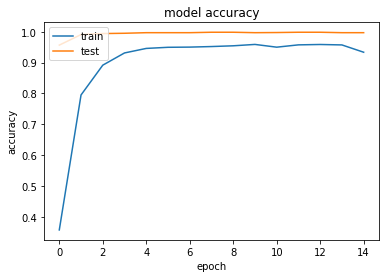

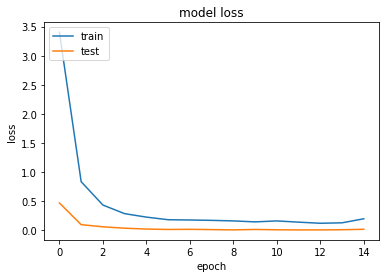

In [0]:
# Plot Accuracy and Loss

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Get mapping  for predictions
class_to_index = train_generator.class_indices
label_map = dict((v,k) for k,v in class_to_index.items()) 
label_map

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '16',
 8: '17',
 9: '2',
 10: '20',
 11: '21',
 12: '22',
 13: '24',
 14: '3',
 15: '33',
 16: '34',
 17: '36',
 18: '37',
 19: '38',
 20: '39',
 21: '4',
 22: '40',
 23: '41',
 24: '42',
 25: '43',
 26: '44',
 27: '45',
 28: '46',
 29: '47',
 30: '48',
 31: '49',
 32: '5',
 33: '50',
 34: '51',
 35: '52',
 36: '53',
 37: '54',
 38: '55',
 39: '56',
 40: '57',
 41: '58',
 42: '59',
 43: '6',
 44: '60',
 45: '61',
 46: '62',
 47: '63',
 48: '64',
 49: '65',
 50: '66',
 51: '67',
 52: '68',
 53: '69',
 54: '7',
 55: '70',
 56: '71',
 57: '72',
 58: '73',
 59: '74',
 60: '75',
 61: '76',
 62: '77',
 63: '78',
 64: '79',
 65: '8',
 66: '80',
 67: '81',
 68: '9'}

In [0]:
# Batch Predictions
def get_classes(preds, label_map):
  predictions = np.argmax(preds, axis=-1)
  class_preds = [label_map[k] for k in predictions]
  return class_preds

test_probs = model.predict_generator(valid_generator, steps=step_size_valid)
test_preds = get_classes(test_probs, label_map)
print(test_preds)

['9', '46', '3', '53', '76', '17', '59', '51', '79', '47', '41', '2', '20', '4', '1', '20', '59', '73', '49', '37', '12', '15', '38', '2', '55', '77', '41', '2', '47', '22', '3', '65', '50', '44', '24', '54', '47', '53', '22', '8', '44', '8', '3', '61', '75', '52', '43', '56', '49', '22', '54', '61', '52', '74', '48', '40', '15', '10', '9', '64', '36', '73', '77', '37', '7', '66', '74', '60', '53', '53', '38', '68', '45', '77', '54', '49', '70', '10', '48', '61', '22', '45', '63', '51', '3', '42', '12', '52', '64', '20', '68', '48', '10', '13', '41', '40', '81', '2', '73', '22', '65', '17', '47', '42', '38', '13', '71', '22', '58', '10', '61', '54', '44', '36', '49', '66', '2', '73', '24', '2', '22', '34', '73', '58', '59', '38', '44', '64', '7', '69', '56', '73', '5', '45', '16', '77', '59', '66', '41', '4', '6', '6', '2', '40', '10', '16', '2', '52', '45', '54', '48', '68', '70', '77', '61', '61', '81', '51', '72', '24', '9', '53', '7', '63', '20', '74', '21', '3', '5', '81', '75', '

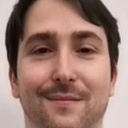

['17']


In [0]:
# Indivdual Predictions
def transform_img(img, show=False):
    img = cv2.resize(img, (224,224))
    img_tensor = np.expand_dims(img, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    return img_tensor

juan = cv2.imread("juan.jpg")
cv2_imshow(juan)

juan_67 = transform_img(juan)
pred = model.predict(juan_67)

guess = get_classes(pred, label_map)
print(guess)

#### Save Models and Data

In [0]:
# Save Models and Data
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/models/v3

joblib.dump(label_map, 'cnn_labelmap.pkl')

#python save
joblib.dump(svmSIFT, "model_VGG16.pkl")

#keras save
model.save('model_VGG16.h5')

/content/drive/My Drive/City Msc Data Science/ComputerVision/models/v3


# MobileNet (doesn't work)

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D, Dropout, Flatten
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=Flatten()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
preds=Dense(69,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

for i,layer in enumerate(model.layers):
  print(i,layer.name, layer.trainable)

0 input_10 False
1 conv1_pad False
2 conv1 False
3 conv1_bn False
4 conv1_relu False
5 conv_dw_1 False
6 conv_dw_1_bn False
7 conv_dw_1_relu False
8 conv_pw_1 False
9 conv_pw_1_bn False
10 conv_pw_1_relu False
11 conv_pad_2 False
12 conv_dw_2 False
13 conv_dw_2_bn False
14 conv_dw_2_relu False
15 conv_pw_2 False
16 conv_pw_2_bn False
17 conv_pw_2_relu False
18 conv_dw_3 False
19 conv_dw_3_bn False
20 conv_dw_3_relu False
21 conv_pw_3 False
22 conv_pw_3_bn False
23 conv_pw_3_relu False
24 conv_pad_4 False
25 conv_dw_4 False
26 conv_dw_4_bn False
27 conv_dw_4_relu False
28 conv_pw_4 False
29 conv_pw_4_bn False
30 conv_pw_4_relu False
31 conv_dw_5 False
32 conv_dw_5_bn False
33 conv_dw_5_relu False
34 conv_pw_5 False
35 conv_pw_5_bn False
36 conv_pw_5_relu False
37 conv_pad_6 False
38 conv_dw_6 False
39 conv_dw_6_bn False
40 conv_dw_6_relu False
41 conv_pw_6 False
42 conv_pw_6_bn False
43 conv_pw_6_relu False
44 conv_dw_7 False
45 conv_dw_7_bn False
46 conv_dw_7_relu False
47 conv_pw_7 Fa

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy


early_stop = EarlyStopping(patience=3)

step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size


history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=14,
                    validation_data=valid_generator,
	                  validation_steps=step_size_valid)

Epoch 1/14


KeyboardInterrupt: ignored

In [0]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

66/66 [==============================] - 23s 350ms/step


[3.9895266522487645, 0.2349311819023355]

# ResNet (doesn't work)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [0]:

# create the base pre-trained model
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling='max', classes=69)



# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(69, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True



154/155 [============================>.] - ETA: 0s - loss: 15.8663

KeyboardInterrupt: ignored

In [0]:
model = createModel()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

155
66


In [0]:

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
155/155 [==============================] - 86s 552ms/step - loss: 4.2369 - acc: 0.0103 - val_loss: 4.2341 - val_acc: 0.0147
Epoch 2/10
155/155 [==============================] - 79s 511ms/step - loss: 4.2351 - acc: 0.0119 - val_loss: 4.2341 - val_acc: 0.0147
Epoch 3/10
155/155 [==============================] - 77s 498ms/step - loss: 4.2351 - acc: 0.0115 - val_loss: 4.2339 - val_acc: 0.0157
Epoch 4/10
155/155 [==============================] - 78s 500ms/step - loss: 4.2394 - acc: 0.0141 - val_loss: 4.2341 - val_acc: 0.0152
Epoch 5/10
155/155 [==============================] - 77s 498ms/step - loss: 4.2351 - acc: 0.0115 - val_loss: 4.2341 - val_acc: 0.0142
Epoch 6/10
155/155 [==============================] - 78s 502ms/step - loss: 4.2348 - acc: 0.0145 - val_loss: 4.2341 - val_acc: 0.0142
Epoch 7/10
155/155 [==============================] - 78s 502ms/step - loss: 4.2349 - acc: 0.0105 - val_loss: 4.2340 - val_acc: 0.0157
Epoch 8

In [0]:
model.evaluate_generator(generator=valid_generator)

In [0]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

In [0]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

Sources Consulted

https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720